RatesLib Bootstrapping: Offshore KRW (BGN) Swap Curve

Solving Method 1 (Linear Simple Zero)...
SUCCESS: `func_tol` reached after 7 iterations (levenberg_marquardt), `f_val`: 1.3485166282299757e-15, `time`: 0.0402s
Solving Method 2 (Flat Forward)...
SUCCESS: `func_tol` reached after 7 iterations (levenberg_marquardt), `f_val`: 1.367129491362314e-15, `time`: 0.0391s
Solving Method 3 (Linear CC Zero)...
SUCCESS: `func_tol` reached after 7 iterations (levenberg_marquardt), `f_val`: 1.3491965805544167e-15, `time`: 0.0402s

Bootstrapped CC Zero Rates:
Tenor  Maturity   Par Rate   Method 1   Method 2   Method 3  
------------------------------------------------------------------------------------------
3M     0.252778   0.027600   0.027600   0.027600   0.027600  
6M     0.505556   0.027050   0.027050   0.027050   0.027050  
9M     0.758333   0.027050   0.027050   0.027050   0.027050  
1Y     1.013889   0.027100   0.027100   0.027100   0.027100  
2Y     2.027778   0.027957   0.027962   0.0279

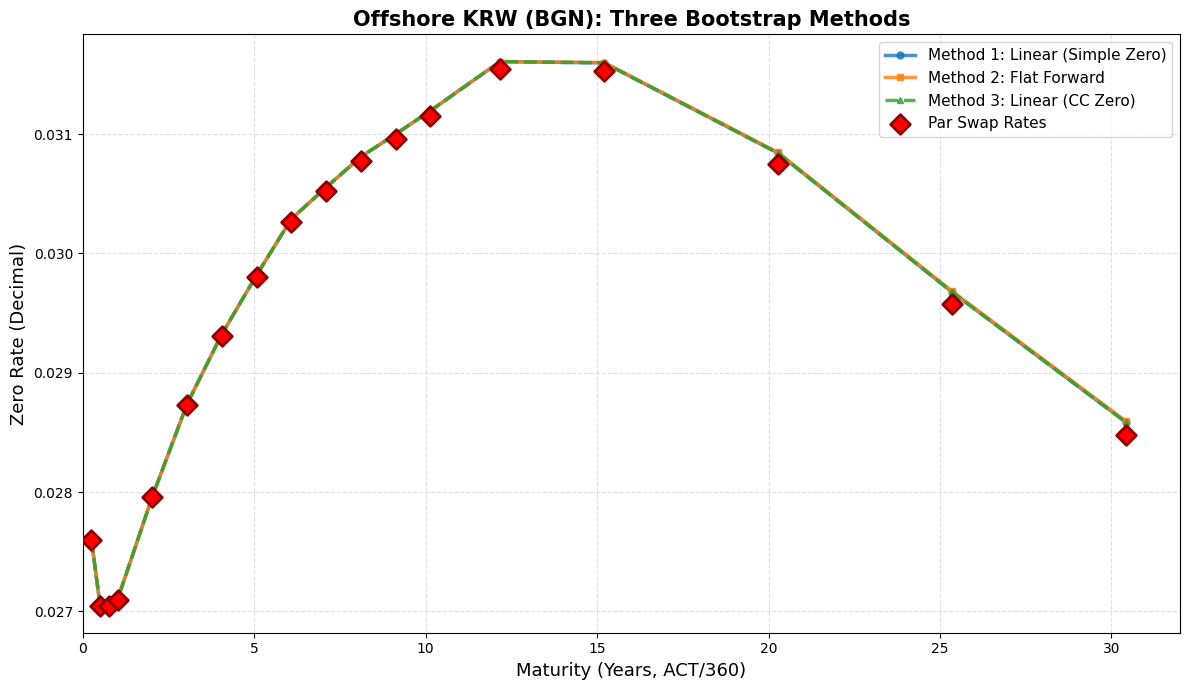

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import rateslib as rl

# Your BGN (offshore KRW) swap rates - input as DECIMALS
data = {
    '3M': 0.0276,
    '6M': 0.02705,
    '9M': 0.02705,
    '1Y': 0.0271,
    '2Y': 0.0279575,
    '3Y': 0.02873,
    '4Y': 0.02931,
    '5Y': 0.0298,
    '6Y': 0.030265,
    '7Y': 0.030525,
    '8Y': 0.030775,
    '9Y': 0.03096,
    '10Y': 0.03115,
    '12Y': 0.03155,
    '15Y': 0.031525,
    '20Y': 0.03075,
    '25Y': 0.029575,
    '30Y': 0.028475
}

base_date = rl.dt(2025, 11, 25)

print("="*90)
print("RatesLib Bootstrapping: Offshore KRW (BGN) Swap Curve")
print("="*90)

# Method 1: Piecewise Linear (Simple Zero Rate)
curve1 = rl.Curve(
    id="curve1",
    convention="act360",
    calendar="nyc",
    modifier="MF",
    interpolation="linear",  # LINEAR on simple rates
    nodes={**{base_date: 1.0}, **{rl.add_tenor(base_date, t, "MF", "nyc"): 1.0 for t in data.keys()}}
)

# Method 2: Step-Function Forward (CC Forward Rate)
curve2 = rl.Curve(
    id="curve2",
    convention="act360",
    calendar="nyc",
    modifier="MF",
    interpolation="flat_forward",  # Step-function forwards
    nodes={**{base_date: 1.0}, **{rl.add_tenor(base_date, t, "MF", "nyc"): 1.0 for t in data.keys()}}
)

# Method 3: Piecewise Linear (CC Zero Rate)
curve3 = rl.Curve(
    id="curve3",
    convention="act360",
    calendar="nyc",
    modifier="MF",
    interpolation="linear_zero_rate",  # Linear on CC zero rates
    nodes={**{base_date: 1.0}, **{rl.add_tenor(base_date, t, "MF", "nyc"): 1.0 for t in data.keys()}}
)

instr_args = dict(
    effective=base_date,
    frequency="A",
    calendar="nyc",
    convention="act360",
    payment_lag=0,
)

print("\nSolving Method 1 (Linear Simple Zero)...")
solver1 = rl.Solver(
    curves=[curve1],
    instruments=[rl.IRS(termination=t, curves="curve1", **instr_args) for t in data.keys()],
    s=list(data.values())
)

print("Solving Method 2 (Flat Forward)...")
solver2 = rl.Solver(
    curves=[curve2],
    instruments=[rl.IRS(termination=t, curves="curve2", **instr_args) for t in data.keys()],
    s=list(data.values())
)

print("Solving Method 3 (Linear CC Zero)...")
solver3 = rl.Solver(
    curves=[curve3],
    instruments=[rl.IRS(termination=t, curves="curve3", **instr_args) for t in data.keys()],
    s=list(data.values())
)

# Extract zero rates at instrument maturities
maturity_dates = [rl.add_tenor(base_date, t, "MF", "nyc") for t in data.keys()]
zeros1 = [float(curve1.rate(base_date, d, "CONT")) for d in maturity_dates]
zeros2 = [float(curve2.rate(base_date, d, "CONT")) for d in maturity_dates]
zeros3 = [float(curve3.rate(base_date, d, "CONT")) for d in maturity_dates]

days = np.array([91,182,273,365,730,1095,1460,1825,2190,2555,2920,3285,3650,4380,5475,7300,9125,10950])
maturities = days / 360.0

# Print results
print("\n" + "="*90)
print("Bootstrapped CC Zero Rates:")
print("="*90)
print(f"{'Tenor':<6} {'Maturity':<10} {'Par Rate':<10} {'Method 1':<10} {'Method 2':<10} {'Method 3':<10}")
print("-"*90)
for i, tenor in enumerate(data.keys()):
    print(f"{tenor:<6} {maturities[i]:<10.6f} {data[tenor]:<10.6f} {zeros1[i]:<10.6f} {zeros2[i]:<10.6f} {zeros3[i]:<10.6f}")
print("="*90)

print(f"\n3M zero rate:")
print(f"  Method 1 (Linear Simple):   {zeros1[0]:.6f}")
print(f"  Method 2 (Flat Forward):    {zeros2[0]:.6f}")
print(f"  Method 3 (Linear CC Zero):  {zeros3[0]:.6f}")

# Plot
plt.figure(figsize=(12, 7))
plt.plot(maturities, zeros1, 'o-', label='Method 1: Linear (Simple Zero)', ms=5, linewidth=2.5, alpha=0.8)
plt.plot(maturities, zeros2, 's-', label='Method 2: Flat Forward', ms=5, linewidth=2.5, alpha=0.8)
plt.plot(maturities, zeros3, '^--', label='Method 3: Linear (CC Zero)', ms=5, linewidth=2.5, alpha=0.8)
plt.scatter(maturities, list(data.values()), marker='D', c='red', s=100,
            label='Par Swap Rates', zorder=5, edgecolors='darkred', linewidths=2)
plt.xlabel('Maturity (Years, ACT/360)', fontsize=13)
plt.ylabel('Zero Rate (Decimal)', fontsize=13)
plt.title('Offshore KRW (BGN): Three Bootstrap Methods', fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, ls='--', alpha=0.4)
plt.xlim(0, 32)
plt.tight_layout()
plt.show()
